In [1]:
import pandas as pd
import tensorflow as tf

In [2]:
df = pd.read_csv('./shared/shared/CANAB_EVAL.csv')
print df.shape
#df['TIMESTAMP'] =df.to_timestamp(df['EVAL_DATE']) 
#df = df.groupby('SMILES').apply(lambda t: t[t.EVAL_DATE==t.EVAL_DATE.max()])

df.sort_values('EVAL_DATE',ascending=True).drop_duplicates(keep='last',inplace=True)
df.shape
#smiles =result.SMILES
#cat =result.EVAL



/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(206576, 11)


(206576, 11)

In [3]:
smiles =df.SMILES.unique()

vocab = list(set('.'.join(smiles)))

mp = dict()
for i in range(len(vocab)):
    mp[str(vocab[i])] =i 

#ind = pd.get_dummies(smiles)


In [4]:
import numpy as np
def str2ind(a,mp,lmax):
    t= [mp[l[1]] for l in enumerate(a)]
    pad = lmax-len(t)
    t.extend([-1] * pad)
    return t

lmax = max([len(c) for c in smiles])
v = [str2ind(c,mp,lmax) for c in smiles]
#V = np.zeros([len(smiles),lmax,len(vocab)],'uint8')

#v = str2ind(smiles[0],mp,lmax)


In [5]:
sess =tf.InteractiveSession()

In [6]:
def batch_vm2(x, m):
    [input_size, output_size] = m.get_shape().as_list()
    input_shape = tf.shape(x)
    batch_rank = input_shape.get_shape()[0].value - 1
    batch_shape = input_shape[:batch_rank]
    output_shape = tf.concat(0, [batch_shape, [output_size]])
    x = tf.reshape(x, [-1, input_size])
    y = tf.matmul(x, m)
    
    y = tf.reshape(y, output_shape)

    return y

In [7]:
def batch_vm(v, m):
    shape = tf.shape(v)
    rank = shape.get_shape()[0].value
    v = tf.expand_dims(v, rank)
    vm = tf.multiply(v, m)
    
    return tf.reduce_sum(vm, rank-1)

In [8]:
def neural_fingerprint(x,NAtomMax,SmileDim,KernelWidth,nLayers,FPDim):
    
    OH = tf.one_hot(x,SmileDim)
    K = tf.get_variable(shape=[KernelWidth,SmileDim,SmileDim],name='kernel',initializer=tf.constant_initializer(1.0),regularizer = tf.contrib.layers.l1_regularizer(scale = 0.1))
    layers = [OH]
    out=[]
    print nLayers
    for i in range(0,nLayers):
        with tf.variable_scope('Layer_'+str(i)):
            W = tf.get_variable(shape=[SmileDim,SmileDim],
                                initializer=tf.random_normal_initializer(),regularizer=tf.contrib.layers.l2_regularizer(scale =0.1),name='W')
            H = tf.get_variable(shape=[SmileDim,FPDim]
                                ,initializer=tf.random_normal_initializer(),regularizer=tf.contrib.layers.l2_regularizer(scale = 0.1),name='H')
            
            CONV = tf.nn.conv1d(layers[i],K,1,'SAME',name ='CONVOL')
            layers.append(tf.nn.tanh(batch_vm(CONV,W),name='layer'))
            out.append(tf.reduce_sum(tf.nn.softmax(batch_vm(layers[i+1],H)),1,name='out'))
            #out.append(tf.nn.softmax(batch_vm(layers[i+1],H),name='out'))
            
    
    cat = tf.stack(out,axis=1)
    return tf.squeeze(
            tf.layers.max_pooling1d(cat,pool_size=nLayers,strides=1,padding='VALID',data_format='channels_last')
            )
             
    
    


In [9]:
x = tf.placeholder("int32",[None,lmax])
fp = neural_fingerprint(x,lmax,len(vocab),4,10,512)

10


In [10]:
print fp

Tensor("Squeeze:0", dtype=float32)


In [11]:
sess.run(tf.global_variables_initializer())

In [12]:

c = fp.eval(feed_dict ={x:v[0:200]},session =sess)

In [13]:
print c.shape

(200, 512)


<IPython.core.display.Javascript object>


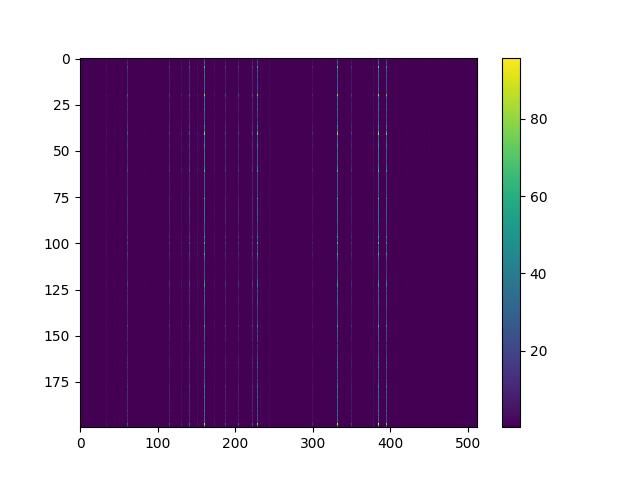

In [14]:
import matplotlib.pyplot as plt

%matplotlib notebook
fig=plt.figure()
h=plt.imshow(c,aspect='auto')
fig.colorbar(h,orientation='vertical')


In [17]:
# see http://ruishu.io/2016/12/27/batchnorm/

fp.set_shape([None,512])
bn = tf.layers.batch_normalization(fp,axis=0)

ValueError: ('Input has undefined `axis` dimension. Input shape: ', TensorShape([Dimension(None), Dimension(512)]))

<IPython.core.display.Javascript object>


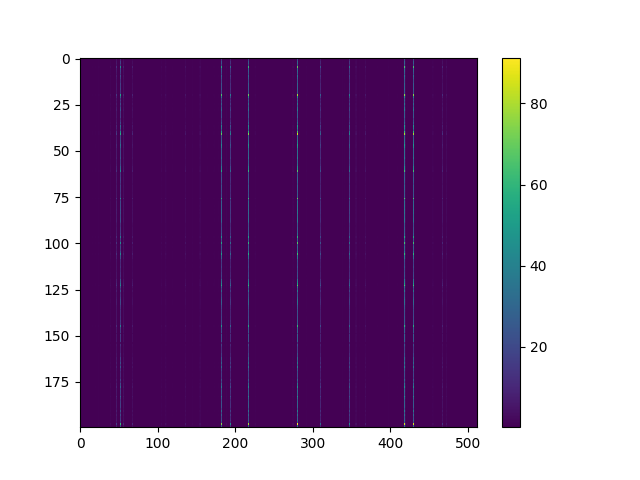

In [16]:
sess.run(tf.global_variables_initializer())
b = bn.eval(feed_dict={x:v[0:200]},session=sess)
fig=plt.figure()
h=plt.imshow(b,aspect='auto')
fig.colorbar(h,orientation='vertical')          